<a href="https://colab.research.google.com/github/KoreTane/MKTBank/blob/main/MKTBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pyspark


# Exploratory Analysis

## Customer Profile
###The profile of our customer is as follows:
* Age Range: Adults in their 40s.
* Marital Status: Predominantly married, with children (which aligns with the average number of children per couple in Europe).
* Profession: Most customers work in administrative, operational, and technical fields.
* Social Class: Customers belong to classes B and C.
* Financial Behavior: They are considered good payers.
Half have a home loan. A small portion has personal credit.

## Technical Profile of Contacts
###The characteristics of the contacts are as follows:
* Contact Method: The majority of interactions are conducted via mobile phone.
* Contact Frequency: Contacts occur more frequently at the end of the year and during the last days of the month, especially starting from the 20th.
* Call Duration: The average duration of calls is between 6 to 7 minutes.
More than half of the calls do not reach this duration, suggesting that many contacts are made with uninterested individuals or those already predisposed to adopting the product.
* Sales Effectiveness: Typically, sales are finalized within three contacts, and half of the customers end up purchasing the product.



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when, col, avg
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # or UserWarning

spark = SparkSession.builder.appName("BankMarketing").getOrCreate()
df = spark.read.csv("bank.csv", header=True, inferSchema=True)
# Create ID Client
df = df.withColumn("client_id", monotonically_increasing_id())

colunas = ['client_id'] + [col for col in df.columns if col != 'client_id']
df = df.select(colunas)

df.show(10)

df.printSchema()

df.summary().show()

+---------+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|client_id|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---------+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|        0| 59|    admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
|        1| 56|    admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
|        2| 41|technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
|        3| 55|  services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|

In [ ]:
total_count = df.count()

distinct_count = df.distinct().count()

if total_count > distinct_count:
    print("Diplicates: Yes.")
else:
    print("Duplicates: No.")

Duplicates: No.


In [ ]:
# Simple Analyses
# 1. age: Count how many IDs are over 80 years old
age_above_80 = df.filter(df.age > 80).count()

# 2. Count IDs grouped by job and calculate the average balance
job_count = df.groupBy("job") \
               .agg(
                   F.count("*").alias("count"),  # Count of IDs
                   F.format_number(F.avg("balance"), 2).alias("average_balance")  # Average balance formatted
               ) \
               .sort(F.col("count").desc())

# 3. marital: Count IDs grouped by marital status
marital_count = df.groupBy("marital").count().sort(col("count").desc())

# 4. Count IDs grouped by education level and calculate the average balance
education_count = df.groupBy("education") \
                     .agg(
                         F.count("*").alias("count"),  # Count of IDs
                         F.format_number(F.avg("balance"), 2).alias("average_balance")  # Average balance formatted
                     ) \
                     .sort(F.col("count").desc())

# 5. default: Count IDs with and without credit in arrears
default_count = df.groupBy("default").count().sort(col("count").desc())

# 6. balance: Count how many IDs have negative and positive balances
balance_count = df.groupBy(F.when(df.balance < 0, "Negative").otherwise("Positive").alias("Balance")).count()

# 7. housing: Count how many IDs have housing loans and how many do not
housing_count = df.groupBy("housing").count().sort(col("count").desc())

# 8. loan: Count how many IDs have loans and how many do not
loan_count = df.groupBy("loan").count().sort(col("count").desc())

# 9. contact: Count the number of IDs grouped by contact method
contact_count = df.groupBy("contact").count().sort(col("count").desc())

# 10. day: Count the distribution of contacts by day of the month
day_count = df.groupBy("day").count().sort(col("count").desc())

# 11. month: Count the distribution of contacts by month
month_count = df.groupBy("month").count().sort(col("count").desc())

# 12. duration: Count how many IDs have contact duration above and below the average
average_duration = df.select(F.avg("duration")).first()[0]
duration_count = df.groupBy(F.when(df.duration < average_duration, "Below Average").otherwise("Above Average").alias("Duration")).count().sort(col("count").desc())

# 13. campaign: Distribution of contacts made during the campaign
campaign_count = df.groupBy("campaign").count().sort(col("count").desc())

# 14. pdays: Distribution of the number of days since the last contact (999 means never contacted)
pdays_count = df.groupBy(F.when(df.pdays == 999, "Never contacted").otherwise(df.pdays)).count().sort(col("count").desc())

# 15. previous: Distribution of the number of previous contacts
previous_count = df.groupBy("previous").count().sort(col("count").desc())

# 16. poutcome: Count results from the previous campaign
poutcome_count = df.groupBy("poutcome").count().sort(col("count").desc())

# 17. deposit: Count acceptance of the offer (yes/no)
deposit_count = df.groupBy("deposit").count()

# Displaying results in a matrix

print("Complete Customer Analysis:")

print(f"\n1. IDs over 80 years old: {age_above_80}")

print("\n2. Count of IDs grouped by Job:")
job_count.show()

print("\n3. Count of IDs grouped by Marital Status:")
marital_count.show()

print("\n4. Count of IDs grouped by Education Level:")
education_count.show()

print("\n5. Count of IDs with and without Credit in Arrears:")
default_count.show()

print("\n6. Count of IDs with Negative and Positive Balance:")
balance_count.show()

print("\n7. Count of IDs with Housing:")
housing_count.show()

print("\n8. Count of IDs with Loan:")
loan_count.show()

print("\n9. Count of IDs grouped by Contact:")
contact_count.show()

print("\n10. Distribution of contacts by Day of the Month:")
day_count.show()

print("\n11. Distribution of contacts by Month:")
month_count.show()

print("\n12. The average is: 371 seconds. Duration of contact (Below/Above Average):")
duration_count.show()

print("\n13. Distribution of contacts made during the Campaign:")
campaign_count.show()

print("\n14. Distribution of Number of Days since Last Contact:")
pdays_count.show()

print("\n15. Distribution of Number of Previous Contacts:")
previous_count.show()

print("\n16. Results from Previous Campaign:")
poutcome_count.show()

print("\n17. Acceptance of Offer (Yes/No):")
deposit_count.show()

Complete Customer Analysis:

1. IDs over 80 years old: 55

2. Count of IDs grouped by Job:
+-------------+-----+---------------+
|          job|count|average_balance|
+-------------+-----+---------------+
|   management| 2566|       1,793.66|
|  blue-collar| 1944|       1,203.93|
|   technician| 1823|       1,556.29|
|       admin.| 1334|       1,195.87|
|     services|  923|       1,081.17|
|      retired|  778|       2,417.25|
|self-employed|  405|       1,865.37|
|      student|  360|       1,500.78|
|   unemployed|  357|       1,314.72|
| entrepreneur|  328|       1,621.94|
|    housemaid|  274|       1,366.16|
|      unknown|   70|       1,945.46|
+-------------+-----+---------------+


3. Count of IDs grouped by Marital Status:
+--------+-----+
| marital|count|
+--------+-----+
| married| 6351|
|  single| 3518|
|divorced| 1293|
+--------+-----+


4. Count of IDs grouped by Education Level:
+---------+-----+---------------+
|education|count|average_balance|
+---------+-----+------

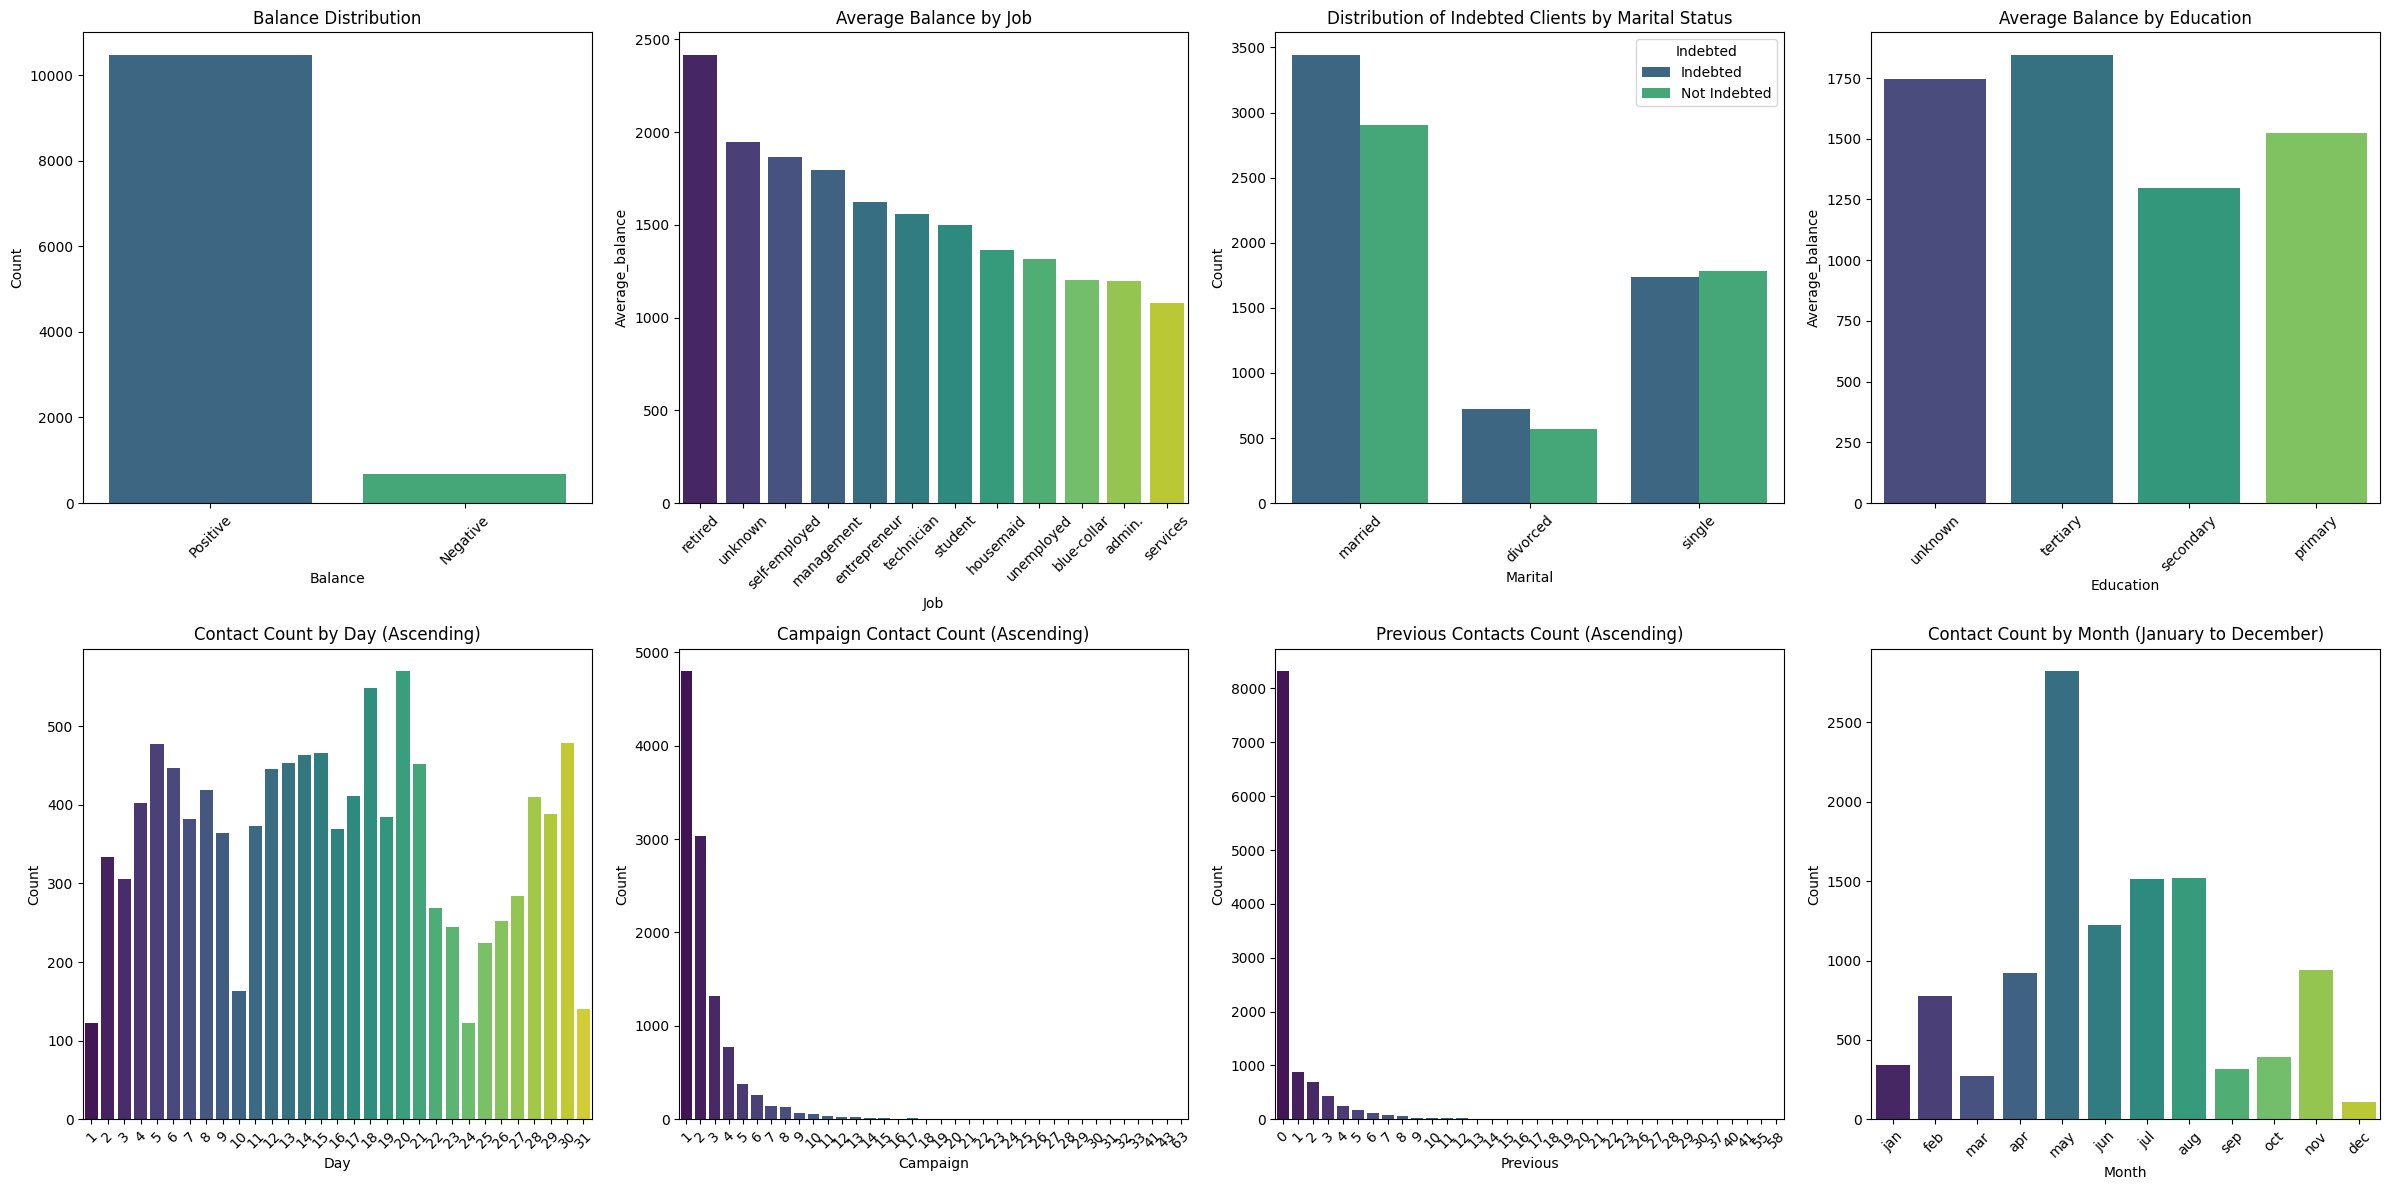

In [ ]:
queries = [
    {
        "query": df.groupBy(F.when(df.balance < 0, "Negative").otherwise("Positive").alias("Balance")).count(),
        "x_col": "Balance",
        "y_col": "count",
        "title": "Balance Distribution",
        "plot_type": "bar"
    },
    {
    "query": df.groupBy("job").agg(F.avg("balance").alias("average_balance")).orderBy(F.col("average_balance").desc()),
    "x_col": "job",
    "y_col": "average_balance",
    "title": "Average Balance by Job",
    "plot_type": "bar"
    },

    {
        "query": df.withColumn("Indebted", F.when((df.housing == "yes") | (df.loan == "yes"), "Indebted").otherwise("Not Indebted"))
                    .groupBy("marital", "Indebted").count(),
        "x_col": "marital",
        "y_col": "count",
        "hue_col": "Indebted",
        "title": "Distribution of Indebted Clients by Marital Status",
        "plot_type": "bar"
    },
    {
        "query": df.groupBy("education").agg(F.avg("balance").alias("average_balance")),
        "x_col": "education",
        "y_col": "average_balance",
        "title": "Average Balance by Education",
        "plot_type": "bar"
    },
    {
        "query": df.groupBy("day").count().orderBy("day"),
        "x_col": "day",
        "y_col": "count",
        "title": "Contact Count by Day (Ascending)",
        "plot_type": "bar"
    },
    {
        "query": df.groupBy("campaign").count().orderBy("campaign"),
        "x_col": "campaign",
        "y_col": "count",
        "title": "Campaign Contact Count (Ascending)",
        "plot_type": "bar"
    },
    {
        "query": df.groupBy("previous").count().orderBy("previous"),
        "x_col": "previous",
        "y_col": "count",
        "title": "Previous Contacts Count (Ascending)",
        "plot_type": "bar"
    },
    {
    "query": df.withColumn("month_index", F.when(df["month"] == "jan", 1)
                                             .when(df["month"] == "feb", 2)
                                             .when(df["month"] == "mar", 3)
                                             .when(df["month"] == "apr", 4)
                                             .when(df["month"] == "may", 5)
                                             .when(df["month"] == "jun", 6)
                                             .when(df["month"] == "jul", 7)
                                             .when(df["month"] == "aug", 8)
                                             .when(df["month"] == "sep", 9)
                                             .when(df["month"] == "oct", 10)
                                             .when(df["month"] == "nov", 11)
                                             .when(df["month"] == "dec", 12)
                                             .otherwise(13))
                    .groupBy("month", "month_index")
                    .count()
                    .orderBy("month_index"),
    "x_col": "month",
    "y_col": "count",
    "title": "Contact Count by Month (January to December)",
    "plot_type": "bar"
}


]

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
axes = axes.flatten()

# Loop plot granp
for ax, query_info in zip(axes, queries):
    df_pd = query_info["query"].toPandas()
    sns.barplot(x=query_info["x_col"], y=query_info["y_col"], hue=query_info.get("hue_col"), data=df_pd, ax=ax, palette="viridis")
    ax.set_title(query_info["title"])
    ax.set_xlabel(query_info["x_col"].capitalize())
    if query_info["y_col"]:
        ax.set_ylabel(query_info["y_col"].capitalize())
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# del lines where age > 80 or balance > 10000
df = df.filter(
    (df.age <= 82) &
    (df.balance <= 10000) &
    (df.balance >= -2000) &
    (df.job != "unknown") &
    (df.education != "unknown") &
    (df.campaign < 12) &
    (df.previous < 10)
)

# Substitute "unknown" for "Not Informed" in colunms contact and poutcome
df = df.withColumn("contact", F.when(df.contact == "unknown", "Not Informed").otherwise(df.contact)) \
       .withColumn("poutcome", F.when(df.poutcome == "unknown", "Not Informed").otherwise(df.poutcome))
# create dataframe secundary
df2 = df.select("*")

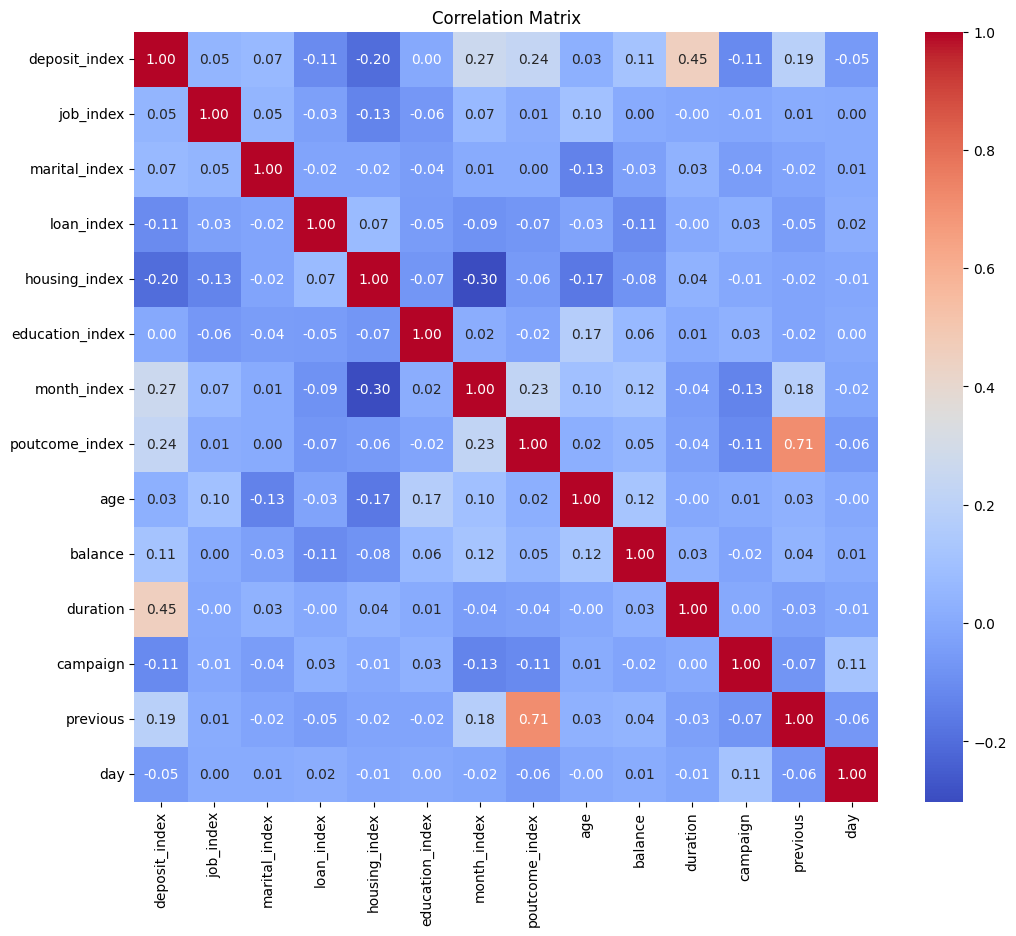

In [ ]:
# Creating the Spark session
spark = SparkSession.builder.appName("CorrelationMatrix").getOrCreate()

categorical_cols = ['deposit','job', 'marital','loan','housing', 'education', 'month','poutcome']
numerical_cols = ['age', 'balance', 'duration','campaign','previous','day']

# Transform categorical variables into numeric ones
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]
for indexer in indexers:
    df = indexer.fit(df).transform(df)

# Select the necessary columns
df_indexed = df.select([F.col(f"{col}_index") for col in categorical_cols] + [F.col(col) for col in numerical_cols])

# Convert to Pandas DataFrame for plotting the correlation matrix
df_pandas = df_indexed.toPandas()

# Calcu the correlation matrix
correlation_matrix = df_pandas.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Assuming df2 is the existing DataFrame
# Creating AgeRange column
df2 = df2.withColumn("AgeRange",
                   when((col("age") >= 18) & (col("age") <= 25), "Jovem")
                   .when((col("age") > 25) & (col("age") <= 35), "Jovem Adulto")
                   .when((col("age") > 35) & (col("age") <= 55), "Adulto")
                   .otherwise("Idoso"))

# Creating Compromised column
df2 = df2.withColumn("Compromised",
                   when(col("marital").isin(["single", "divorced"]), "uncommitted")
                   .otherwise("Married"))

# Creating CampaignInsistence column
df2 = df2.withColumn("CampaignInsistence",
                     when(col("campaign") == 1, "Normal")
                     .when(col("campaign") == 2, "Insist")
                     .otherwise("Very Insist"))

# Creating PorN column
df2 = df2.withColumn("PorN",
                   when(col("balance") > 0, "Positive")
                   .otherwise("Negative"))

# Calculate avereage duration
average_duration = df2.select(avg(col("duration"))).collect()[0][0]

# create a column OccupationStatus
df2 = df2.withColumn("OccupationStatus",
                     when(col("duration") <= average_duration / 3, "Occupied")
                     .when((col("duration") > average_duration / 3) & (col("duration") <= average_duration), "Little Busy")
                     .otherwise("Unoccupied"))


# Creating BalanceCategory column
df2 = df2.withColumn("BalanceCategory",
                     when(col("balance") < 0, "Negative Balance")
                     .when((col("balance") >= 0) & (col("balance") <= 300), "Low Balance")
                     .when((col("balance") > 300) & (col("balance") <= 1000), "Medium Balance")
                     .otherwise("High Balance"))

# Creating DaysM column
df2 = df2.withColumn("DaysM",
                   when((col("day") >= 1) & (col("day") <= 5), "Beginning")
                   .when((col("day") > 5) & (col("day") <= 25), "Middle")
                   .otherwise("End"))

# Creating Trimestry column
df2 = df2.withColumn("Trimestry",
                   when(col("month").isin(["jan", "feb", "mar"]), "Q1")
                   .when(col("month").isin(["apr", "may", "jun"]), "Q2")
                   .when(col("month").isin(["jul", "aug", "sep"]), "Q3")
                   .otherwise("Q4"))

# Creating DurationRecurse column
df2 = df2.withColumn("DurationRecurse",
                   when((col("duration") >= 0) & (col("duration") <= 120), "Short")
                   .when((col("duration") > 120) & (col("duration") <= 240), "Medium")
                   .otherwise("Long"))

# Creating ProfessionGroup column
df2 = df2.withColumn("ProfessionGroup",
                   when(col("job").isin(["management", "entrepreneur", "self-employed"]), "Executives and High Earners")
                   .when(col("job").isin(["technician", "admin.", "blue-collar"]), "Skilled Workers")
                   .when(col("job").isin(["services", "housemaid", "unemployed", "student"]), "Services and Support")
                   .otherwise("Others"))

# Creating DetailedProfile column
df2 = df2.withColumn("DetailedProfile",
                     when((col("marital") == "married") &
                          (col("balance") > 1000) &
                          (col("default") == "yes"), "Married with High Balance but in Default")
                     .when((col("job").isin(["management", "entrepreneur", "self-employed"])), "Stable High Earners")
                     .when((col("balance") > 1000) &
                           (col("job").isin(["management", "engineer", "doctor"])), "High Earners with Financial Issues")
                     .when((col("marital") == "married") &
                          (col("balance") > 1000) &
                          (col("default") == "no") &
                          (col("housing") == "yes"), "Married, Good Balance, Housing Loan")
                     .otherwise("Other Profiles"))

# Displaying the modified DataFrame
df2.show(10)


+---------+---+----------+--------+---------+-------+-------+-------+----+------------+---+-----+--------+--------+-----+--------+------------+-------+------------+-----------+------------------+--------+----------------+---------------+---------+---------+---------------+--------------------+--------------------+
|client_id|age|       job| marital|education|default|balance|housing|loan|     contact|day|month|duration|campaign|pdays|previous|    poutcome|deposit|    AgeRange|Compromised|CampaignInsistence|    PorN|OccupationStatus|BalanceCategory|    DaysM|Trimestry|DurationRecurse|     ProfessionGroup|     DetailedProfile|
+---------+---+----------+--------+---------+-------+-------+-------+----+------------+---+-----+--------+--------+-----+--------+------------+-------+------------+-----------+------------------+--------+----------------+---------------+---------+---------+---------------+--------------------+--------------------+
|        0| 59|    admin.| married|secondary|     no

In [ ]:
# Listing the variables in the DataFrame df
df_columns = set(df.columns)

# Listing the variables in the DataFrame df2
df2_columns = set(df2.columns)

# Finding variables that are unique to df2
df2_unique_columns = df2_columns - df_columns

# Function to display variables in a compact format
def print_columns(columns, title):
    print(f"{title}:")
    col_list = list(columns)
    max_length = max(len(col) for col in col_list)
    col_list = [f"{col:<{max_length + 5}}" for col in col_list]  # Add padding for better spacing
    for i, col in enumerate(col_list, 1):
        print(f"{col}", end='')
        if i % 3 == 0:  # Line break every 3 columns for better spacing
            print()
    print("\n")  # Line break at the end of the list

# Displaying the lists of variables
print_columns(df_columns, "Variables in df")

# Displaying only the unique variables in df2
print_columns(df2_unique_columns, "Unique variables in df2")

#Selected features: Index(['marital_index', 'job_index', 'poutcome_index', 'housing_index',
#Index(['marital_index', 'poutcome_index', 'housing_index', 'month_index',
#       'contact_index', 'DurationRecurse_index', 'OccupationStatus_index',
#      'Trimestry_index', 'CampaignInsistence_index', 'AgeRange_index',
#       'previous', 'day', 'pdays', 'balance'],

Variables in df:
marital             deposit_index       loan                
default             day                 balance             
job                 month               pdays               
campaign            marital_index       poutcome            
age                 previous            client_id           
poutcome_index      education_index     loan_index          
housing             duration            housing_index       
education           month_index         job_index           
contact             deposit             

Unique variables in df2:
CampaignInsistence     DetailedProfile        Compromised            
DaysM                  OccupationStatus       ProfessionGroup        
Trimestry              BalanceCategory        PorN                   
AgeRange               DurationRecurse        



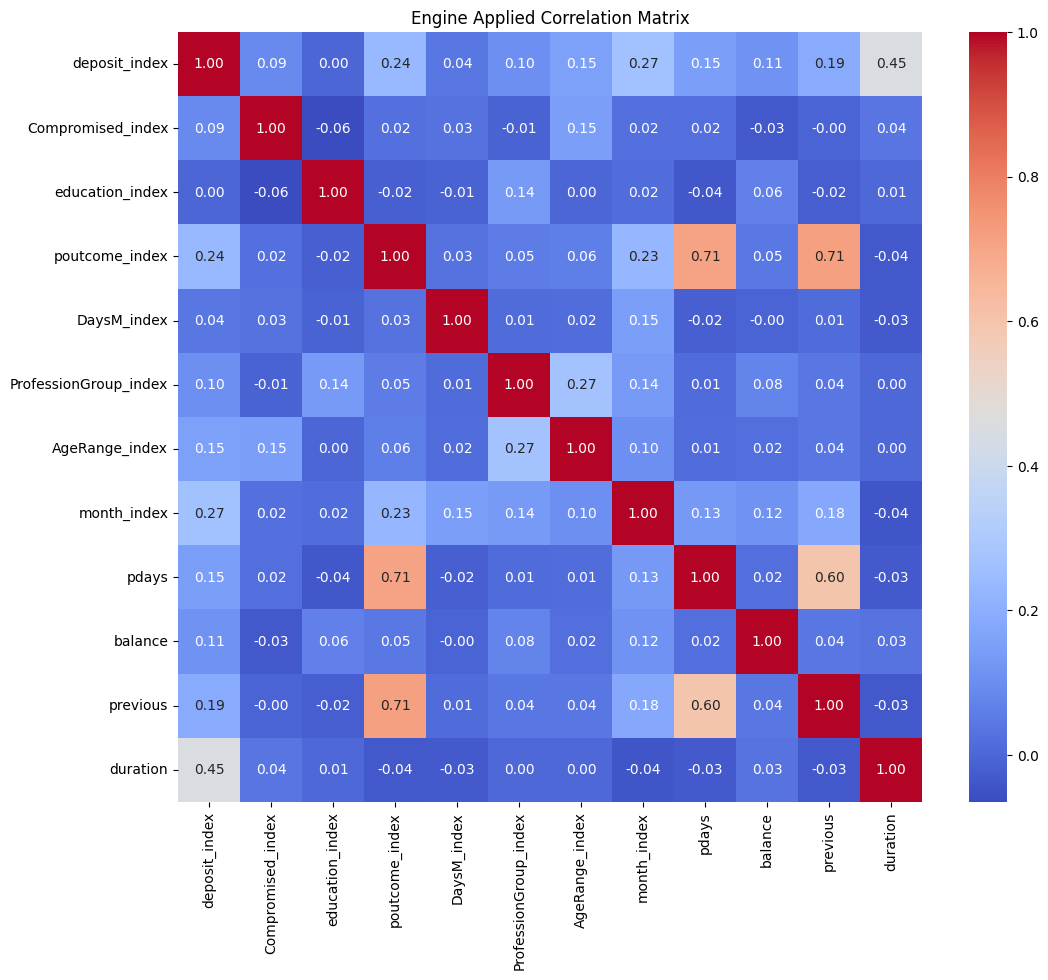

In [ ]:
# Defining categorical and numerical columns
categorical_cols2 = ['deposit','Compromised','education','poutcome','DaysM', 'ProfessionGroup','AgeRange','month']

numerical_cols2 = ['pdays', 'balance','previous','duration']

# Transforming categorical variables into numerical
indexers2 = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols2]
for indexer in indexers2:
    df2 = indexer.fit(df2).transform(df2)

# Selecting the necessary columns
df_indexed2 = df2.select([F.col(f"{col}_index") for col in categorical_cols2] + [F.col(col) for col in numerical_cols2])

# Converting to Pandas DataFrame to calculate the correlation matrix
df_pandas2 = df_indexed2.toPandas()

# Calculating the correlation matrix
correlation_matrix2 = df_pandas2.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Engine Applied Correlation Matrix')
plt.show()

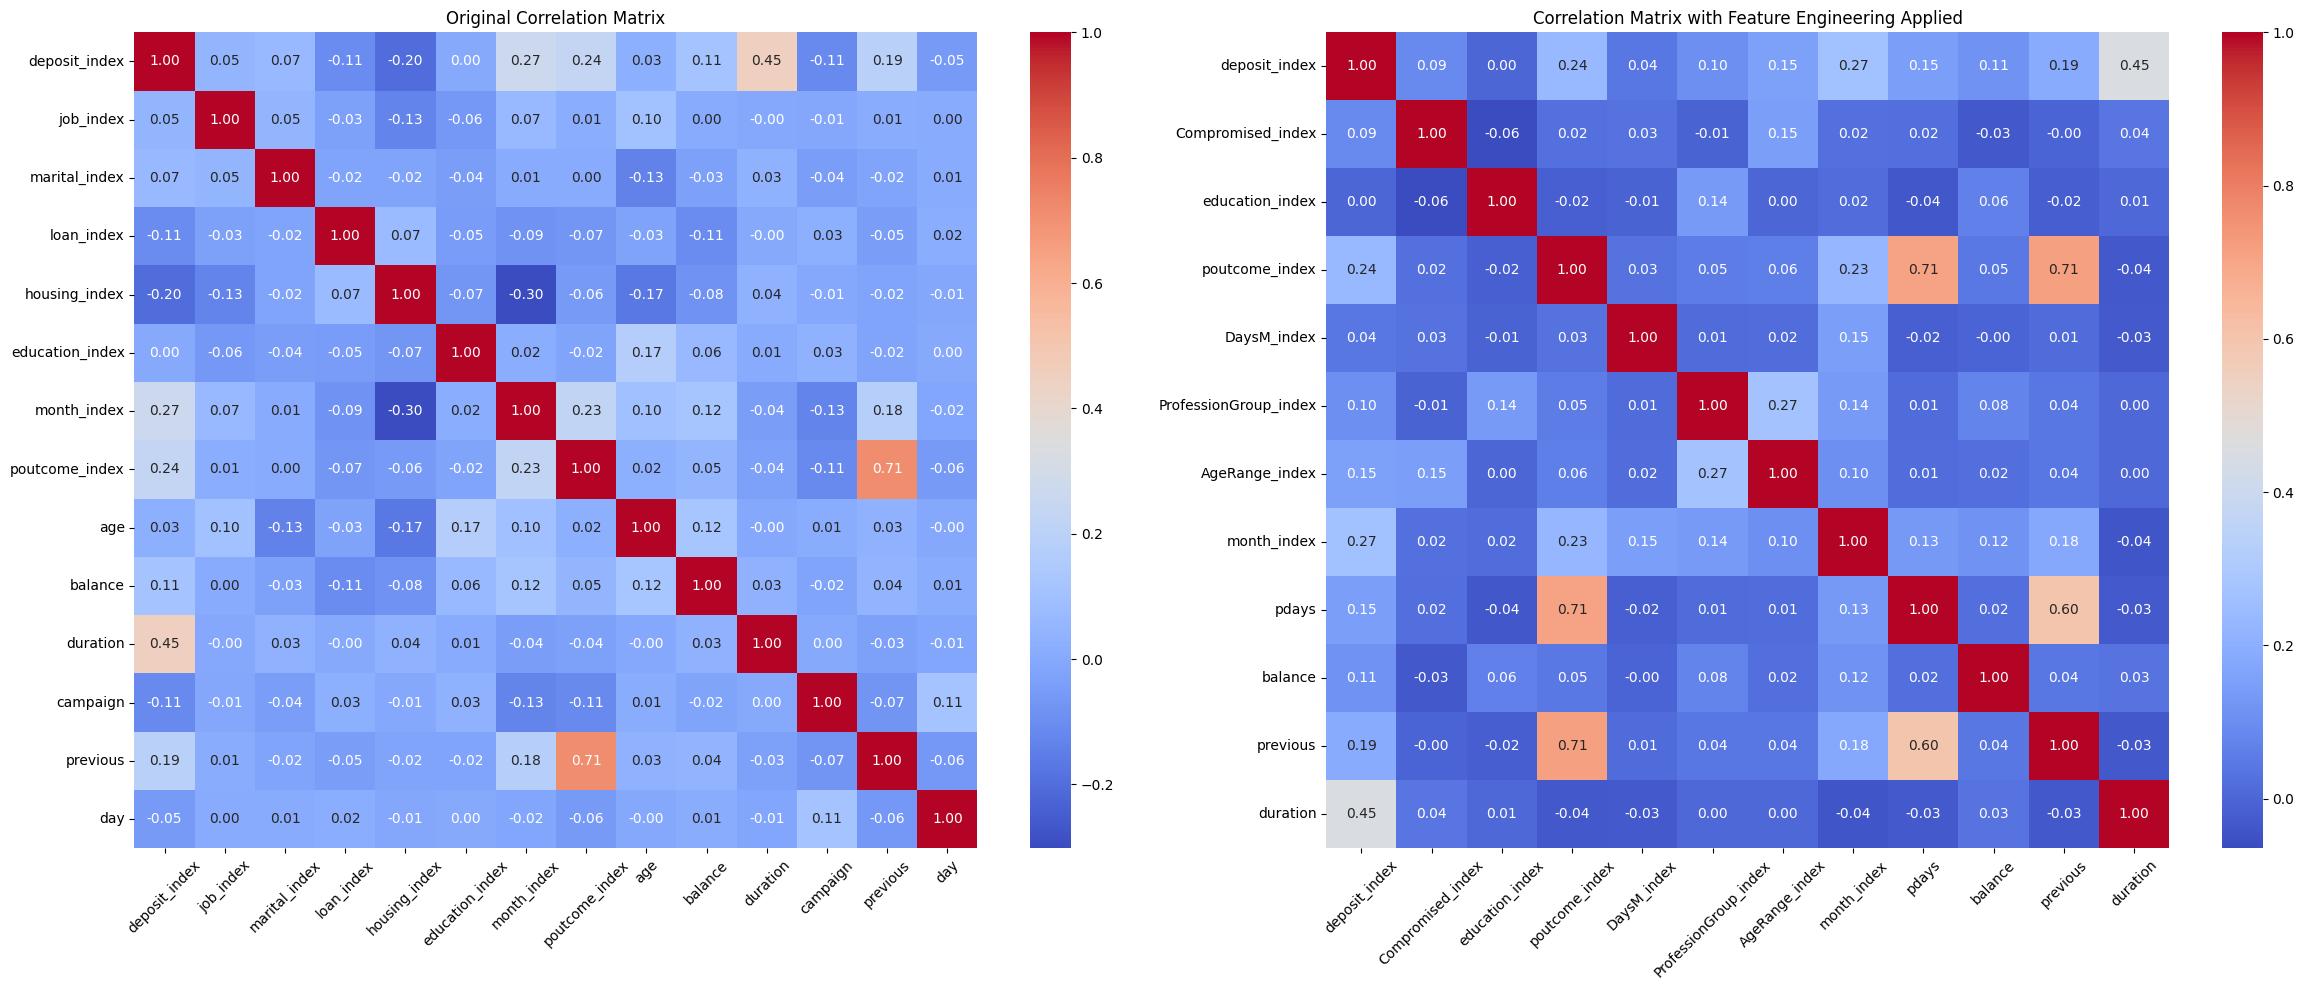

In [ ]:
# Defining the figure size
plt.figure(figsize=(24, 10))  # Increase width to accommodate both charts

# Subplot 1: Original Correlation Matrix
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Original Correlation Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Subplot 2: Applied Feature Engineering Correlation Matrix
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Feature Engineering Applied')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Adjusting layout
plt.tight_layout()
plt.show()

# here we can observe that with resource engineering we were able to reduce the correlation scale and improve the relationship between variables and the target